In [1]:
import numpy as np
import pandas as pd
import mne
import glob
import os
from scipy.signal import resample
from matplotlib import pyplot as plt
from idun_sdk import do_bandpass, prepare_fft
from data_labeler import calculate_bad_epochs

In [2]:
def calculate_lag(signal_1, signal_2):
    '''
    This function calculates the lag between two signals.
    :param signal_1: first signal
    :param signal_2: second signal
    '''
    # check if there is nan in the signals
    if np.isnan(signal_1).any() or np.isnan(signal_2).any():
        # create a nan array with the same length as the signals
        nan_array = np.empty(len(signal_1))
        nan_array[:] = np.nan
        return nan_array, np.nan
    correlation = np.correlate(signal_1, signal_2, mode="full")
    index_of_max_corr = np.argmax(correlation)
    num_samples = len(signal_1)
    lag = index_of_max_corr - (num_samples - 1)
    return correlation, lag

def epoch_data(data, samples_per_epoch):
    """Split the data into epochs."""
    num_epochs = len(data) // samples_per_epoch
    # remove the last epoch if it is not complete
    data = data[:num_epochs * samples_per_epoch]
    return np.array_split(data, num_epochs)

### Variables

In [16]:
FILTER_RANGE = [20,40]
BASE_SAMPLE_RATE = 250

### Upload data

In [17]:
edf_file_path = glob.glob(os.path.join("data", '*.edf'))[0]
csv_file_path = glob.glob(os.path.join("data", '*.csv'))[0]

prodigy_raw_data = mne.io.read_raw_edf(edf_file_path, preload=True)

# upload csv file using numpy
idun_raw_data = np.genfromtxt(csv_file_path, delimiter=',', skip_header=1)

### Unpack prodigy

(0.0, 5.0)

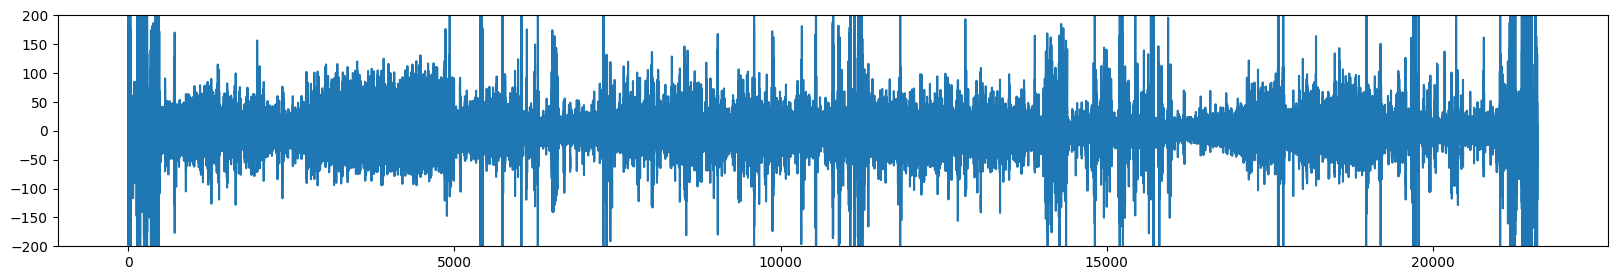

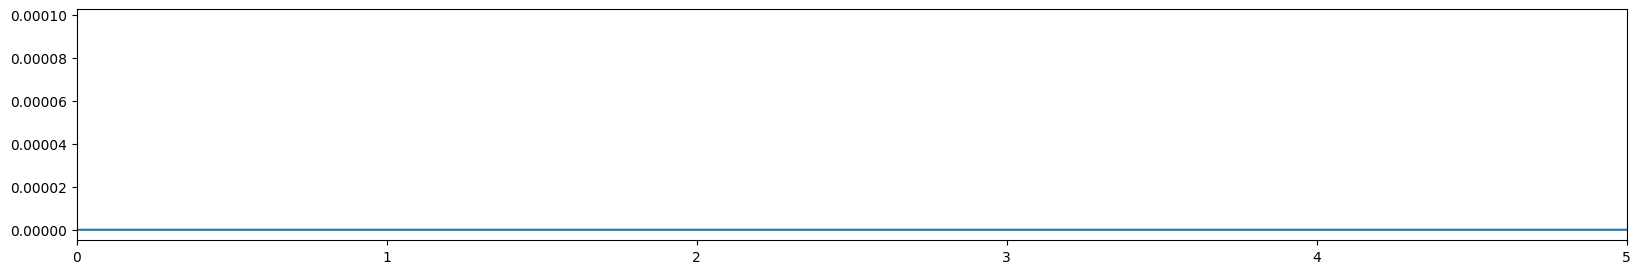

In [18]:
CHANNEL_1 = "LEFT_EYE"
CHANNEL_2 = "RIGHT_EYE"
PRODIGY_SAMPLE_RATE = 120
prodigy_data, prodigy_times = prodigy_raw_data[:, :]
prodigy_channel_names = prodigy_raw_data.ch_names

# find the position of the channels in channel_names
channel_1_index = prodigy_channel_names.index(CHANNEL_1)
channel_2_index = prodigy_channel_names.index(CHANNEL_2)
# extract the data from the channels
prodigy_channel_1_data = prodigy_data[channel_1_index, :]
prodigy_channel_2_data = prodigy_data[channel_2_index, :]
# minus right eye from left eye
prodigy_channel_1_minus_2 = prodigy_channel_1_data - prodigy_channel_2_data
prodigy_channel_1_minus_2 = prodigy_channel_1_minus_2*1000000

# Upsample to 250 Hz
num_samples_250 = int(BASE_SAMPLE_RATE/PRODIGY_SAMPLE_RATE*len(prodigy_channel_1_minus_2))
resampled_prodigy_data = resample(prodigy_channel_1_minus_2, num_samples_250)

# Filter
prodigy_filtered_data_rs = do_bandpass(resampled_prodigy_data,  [FILTER_RANGE[0], FILTER_RANGE[1]], BASE_SAMPLE_RATE)
resampled_times = np.linspace(0, len(prodigy_filtered_data_rs)/BASE_SAMPLE_RATE, len(prodigy_filtered_data_rs))


plt.figure(figsize=(20, 3))
plt.plot(resampled_times, resampled_prodigy_data)
plt.ylim(-200, 200)

pr_freqs_rs, pr_fft_rs = prepare_fft(prodigy_filtered_data_rs, 0,20, BASE_SAMPLE_RATE)
plt.figure(figsize=(20, 3))
plt.plot(pr_freqs_rs, pr_fft_rs)
plt.xlim(0, 5)


### Unpack IDUN

(0.0, 5.0)

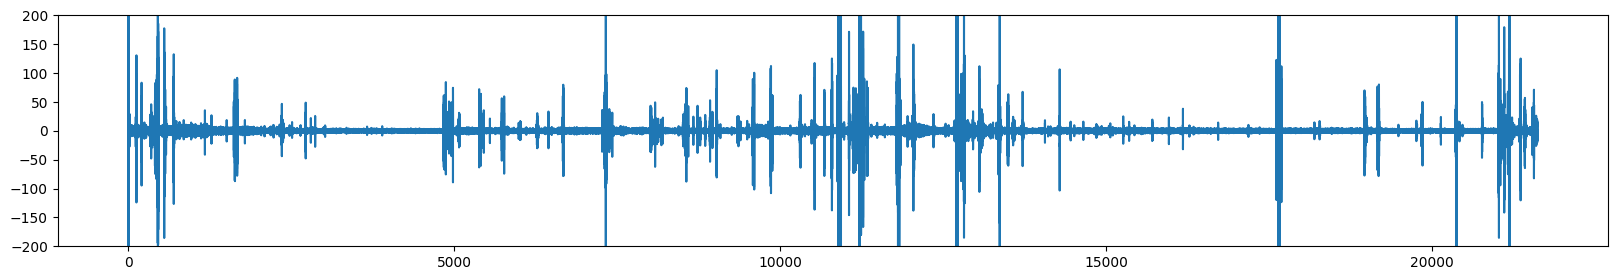

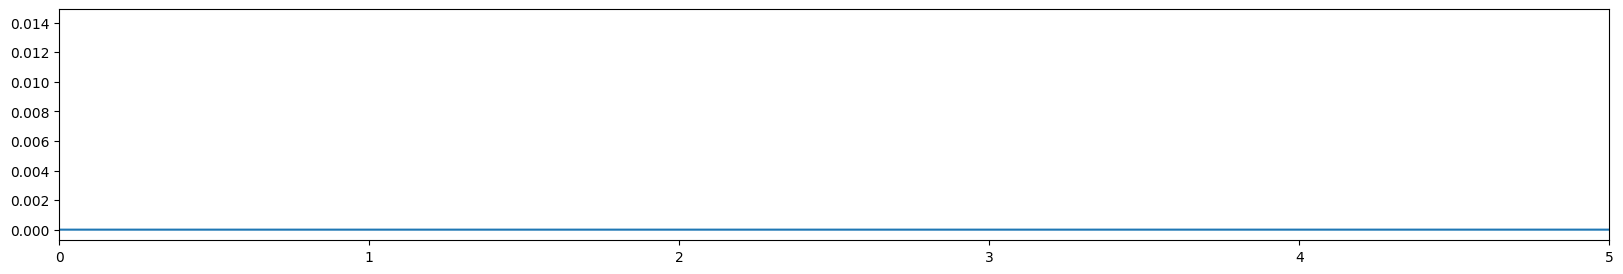

In [19]:
IDUN_SAMPLE_RATE = 250
idun_data = idun_raw_data[:,1]
idun_time_stamps = idun_raw_data[:,0]
idun_time_stamps = idun_time_stamps - idun_time_stamps[0]

# bandpass filter
idun_filtered_data = do_bandpass(idun_data, [FILTER_RANGE[0], FILTER_RANGE[1]], IDUN_SAMPLE_RATE)
plt.figure(figsize=(20, 3))
plt.plot(idun_time_stamps, idun_filtered_data)
plt.ylim(-200, 200)

id_freqs, id_fft = prepare_fft(idun_filtered_data, 0,30 ,IDUN_SAMPLE_RATE)
plt.figure(figsize=(20, 3))
plt.plot(id_freqs, id_fft)
plt.xlim(0,5)

### Clean data

In [37]:
prodigy_labels, prodigy_epoch_freq_powers = calculate_bad_epochs(prodigy_filtered_data_rs, sfreq = BASE_SAMPLE_RATE, outlier_threshold = 6, epoch_length = BASE_SAMPLE_RATE)
prodigy_cleaned_data = np.where(prodigy_labels == 1, np.nan, prodigy_filtered_data_rs)
prodigy_cleaned_data = prodigy_filtered_data_rs
idun_labels, idun_epoch_freq_powers = calculate_bad_epochs(idun_filtered_data, sfreq = BASE_SAMPLE_RATE, outlier_threshold = 6, epoch_length = BASE_SAMPLE_RATE)
idun_cleaned_data = np.where(idun_labels == 1, np.nan, idun_filtered_data)
idun_cleaned_data = idun_filtered_data

# Find which one is longer and how much longer
if len(prodigy_cleaned_data) > len(idun_cleaned_data):
    longer_len = len(prodigy_cleaned_data)
    shorter_len = len(idun_cleaned_data)
    diff = int(longer_len - shorter_len)
    prodigy_cleaned_data = prodigy_cleaned_data[int(diff/2):int(-diff/2)]
else:
    longer_len = len(idun_cleaned_data)
    shorter_len = len(prodigy_cleaned_data)
    diff = int(longer_len - shorter_len)
    idun_cleaned_data = idun_cleaned_data[int(diff/2):int(-diff/2)]
    
same_times = np.linspace(0, len(idun_cleaned_data)/BASE_SAMPLE_RATE, len(idun_cleaned_data))


5400000
5400000


(-200.0, 200.0)

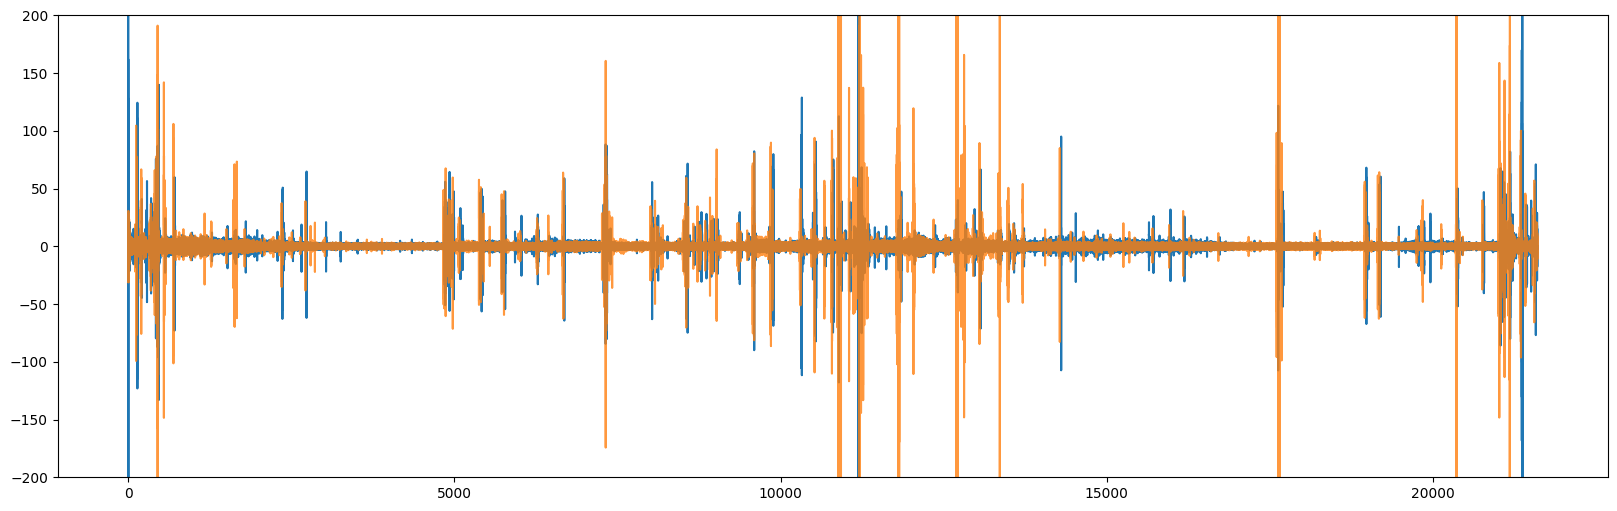

In [38]:
plt.figure(figsize=(20, 6))
# make 0s 1s and 1s 0s in prodigy_labels
plt.plot(same_times, prodigy_cleaned_data)
plt.ylim(-200, 200)
print(len(prodigy_cleaned_data))
# make 0s 1s and 1s 0s in prodigy_labels
plt.plot(same_times, 0.8*idun_cleaned_data, alpha = 0.8)
print(len(idun_cleaned_data))
plt.ylim(-200, 200)

### Validation

Lag: -1


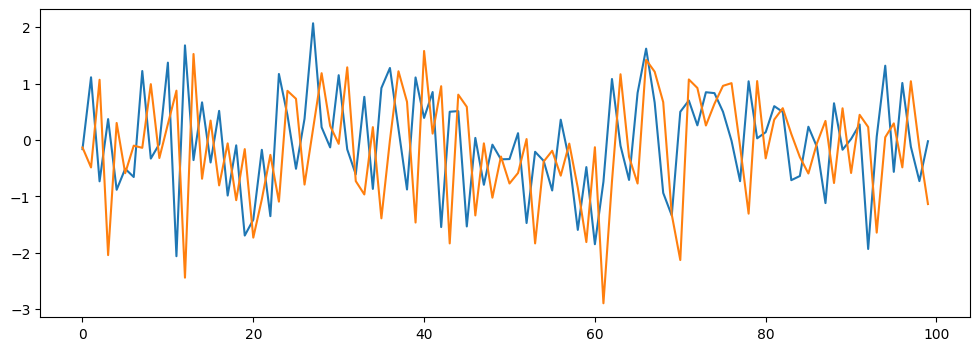

In [39]:
# create s sine wave with numpy
num_samples = 100
shift = 1
# create a random signal with numpy
random_signal = np.random.randn(num_samples)
random_signal_shifted = np.roll(random_signal, shift) 
# add small noise to the signal
random_signal_shifted += np.random.randn(num_samples) * 0.4

correlation, lag = calculate_lag(random_signal, random_signal_shifted)

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(random_signal)
plt.plot(random_signal_shifted)

print(f"Lag: {lag}")

### Calculate lag

In [40]:
samples_per_epoch = BASE_SAMPLE_RATE * 2 * 60

prodigy_epochs = epoch_data(prodigy_cleaned_data, samples_per_epoch)
idun_epochs = epoch_data(idun_cleaned_data, samples_per_epoch)

### Notes
1. Initial sync should be done manually
2. Epochs should be smaller
3. Use also intensit of correlations
4. Normalise the signal

In [41]:
correlation_arr = []
lag_arr = []
max_corr_arr = []
for idx, epoch in enumerate(prodigy_epochs):
    
    
    corr, lag = calculate_lag(epoch, idun_epochs[idx])
    # chekck that lag is not nan
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    plt.plot(epoch, label="prodigy")
    plt.plot(0.8*idun_epochs[idx], label="idun")
    correlation_arr.append(corr)
    lag_arr.append(lag)


/var/folders/z6/9xfx7slx70vby8pq0t9tcmk00000gn/T/ipykernel_16561/1232111873.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1, figsize=(12, 4))


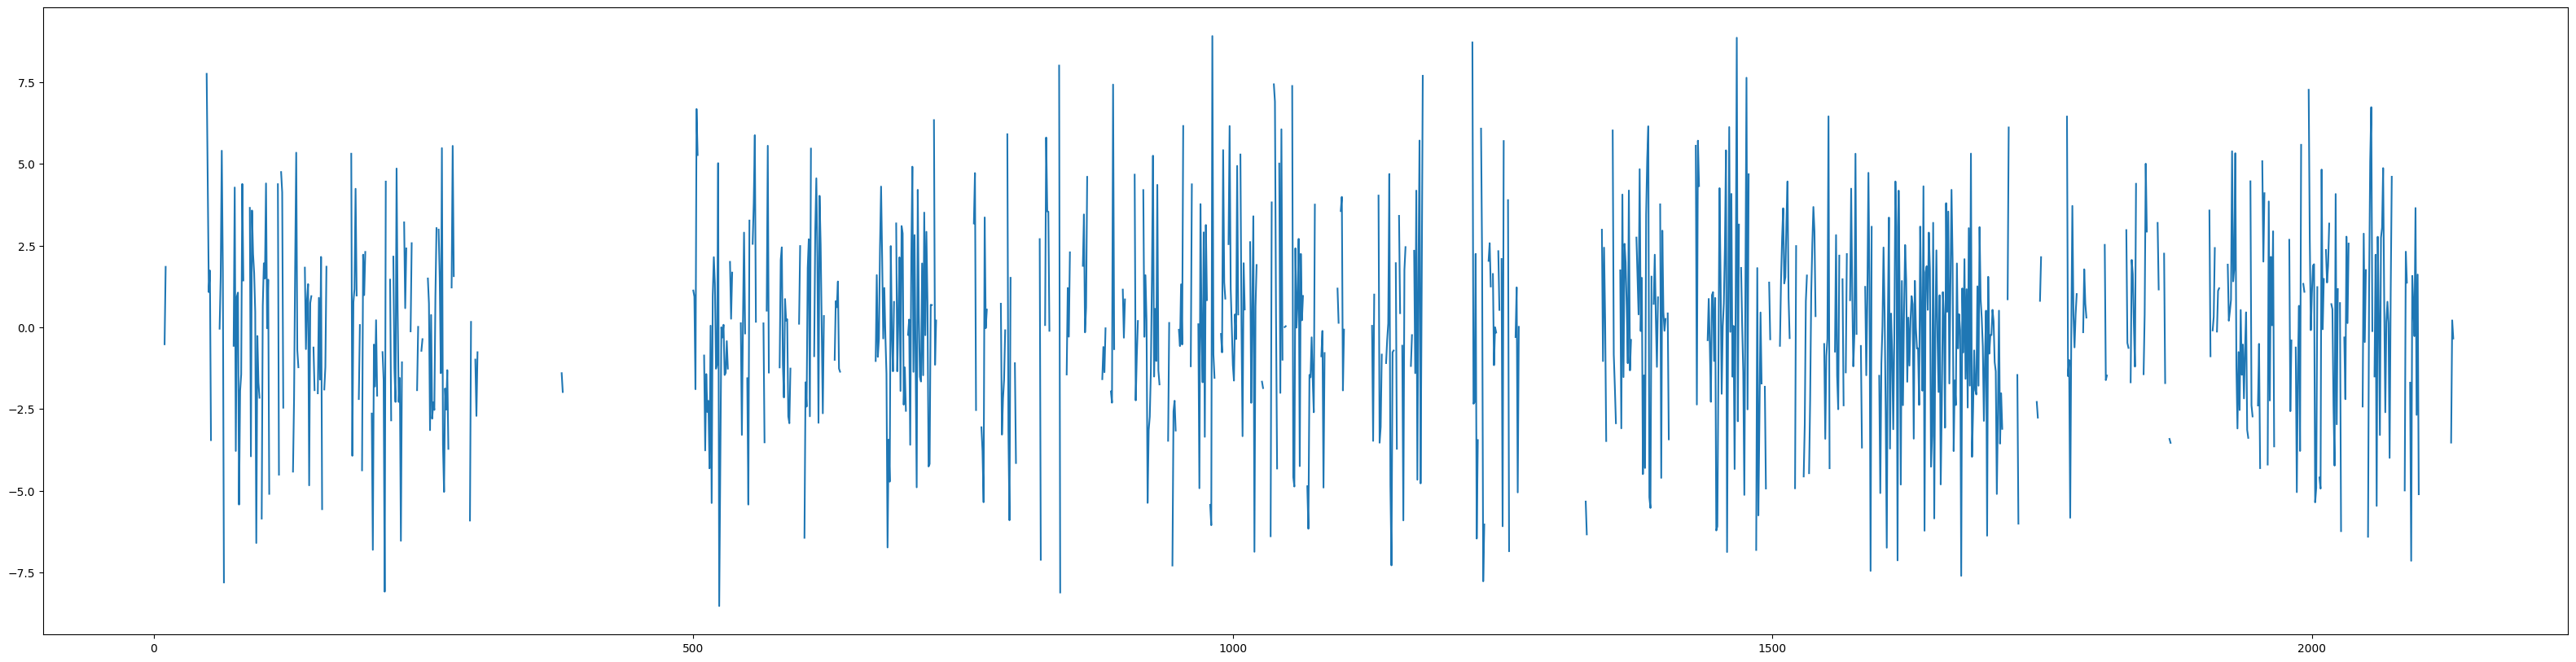

In [68]:


# Assuming the above code, we just continue:
plt.figure(figsize=(40, 10))
plt.plot(np.array(lag_arr)/250)

In [15]:
correlation

array([-2.88754714e-02,  1.68570740e-01,  5.37803016e-01, -1.23896630e+00,
        1.83445844e+00, -4.95250828e+00,  4.60165675e+00, -3.58868061e+00,
        3.26592889e+00,  1.08135335e+00,  1.23535808e+00, -1.84484131e+00,
        2.84689619e+00, -1.79053950e+00, -6.50207510e+00,  3.05104017e+00,
       -3.78108319e-01,  8.91673518e-01,  5.19031625e-01,  2.68644735e-01,
       -5.13094980e+00,  3.33257601e+00,  1.41761635e+00,  3.59583979e+00,
       -5.69547092e+00,  1.43907377e+00, -2.94300967e+00, -3.38907724e+00,
        3.43744389e+00,  2.99847184e+00,  5.67797947e-01, -3.95580239e+00,
        6.26385390e+00, -2.59603950e+00, -8.17626293e+00, -8.30485458e+00,
        4.23114448e+00,  3.19136984e+00, -3.94015388e+00,  5.42303477e+00,
       -1.14230564e+00, -8.95617160e-01, -5.26488168e+00, -3.16238002e+00,
        6.27458882e+00,  1.03819826e+00,  8.73148335e+00, -1.20381281e+01,
       -1.20955831e+00,  7.30692472e+00, -1.13819925e+01, -5.75360199e+00,
        4.50003960e+00,  